# Fitting in silico Marques to in vivo

purpose: high background noise degrades spike sorting. We characterized in vivo background noise and validated ours against in vivo's.

method:

* In vivo traces' mean were removed and the traces were centered around 0, so we removed the mean from each recording site.
* find a recording site from layer 1 (mean absolute deviation estimation of noise is the least biased in L1, because L1 has the lowest firing rate across layers) in Marques dataset and in silico.
* We fitted in silico preprocessed traces to in vivo preprocessed traces to match their 1) max signal and 2) background noises (minimum mean absolute deviation) 
* Missing background noise was modelled as independent noise on each recording sites (a different noise process was added to each site), this matters for spike sorting whitening step.
* Raw silico traces will be scaled and the fitted missing noise will be added to for all subsequent analyses.


**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Neuropixels` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 40.0kHz
    * 10 min
    * "Spontaneous activity" (Only anesthetized condition)

The pipelines:

```bash
sbatch cluster/processing/fitting/marques/fit_marques_silico_l1.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l2_3.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l4.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l5.sbatch
sbatch cluster/processing/fitting/marques/fit_marques_silico_l6.sbatch
```

### Setup libs

Activate `npx_10m_384ch_unit_classes` venv

In [9]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import spikeinterface.extractors as se 
import os
import spikeinterface as si
import spikeinterface.full as si_full
import spikeinterface.preprocessing as spre
import pandas as pd
from scipy.optimize import minimize
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import copy

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import amplitude
from src.nodes.prepro import preprocess, trace_fitting
from src.nodes.dataeng.silico import recording



# SETUP PARAMETERS
RND_SEED = 0                # random seed
SFREQ_VIVO = 30000          # sampling frequency
SFREQ_SILICO = 40000        # sampling frequency
WIND_END = 3700             # last segment to calculate mad
SITE_VIVO = 383             # set a site in layer 1 (unbiased estimate of background noise because low activity?)
SITE_SILICO = 360           # set a site in layer 1 (unbiased estimate of background noise because low activity?)


# HORVATH (vivo)
EXPERIMENT_h_vivo = "vivo_marques"
SIMULATION_h_vivo = "c26"
data_conf_h_vivo, param_conf_h_vivo = get_config(
    EXPERIMENT_h_vivo, SIMULATION_h_vivo
).values() 
RAW_PATH_h_vivo = data_conf_h_vivo["raw"]
PREP_PATH_h_vivo = data_conf_h_vivo["preprocessing"]["output"]["trace_file_path"]
CONTACTS_h = np.arange(0,128,1)


# HORVATH (silico)
EXPERIMENT_h_silico = "silico_neuropixels"
SIMULATION_h_silico = "2023_10_18"
data_conf_h_silico, param_conf_h_silico = get_config(
    EXPERIMENT_h_silico, SIMULATION_h_silico
).values()
RAW_PATH_h_silico = data_conf_h_silico["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_h_silico = data_conf_h_silico["preprocessing"]["output"]["trace_file_path"]
MISSING_NOISE_PATH = data_conf_h_silico["preprocessing"]["fitting"]["missing_noise_path"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-01-03 15:45:07,591 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-03 15:45:07,601 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-01-03 15:45:07,603 - root - utils.py - get_config - INFO - Reading experiment config.
2024-01-03 15:45:07,615 - root - utils.py - get_config - INFO - Reading experiment config. - done


### If data already exists

In [10]:
# if already fitted results exist
missing_noise_L1 = np.load(MISSING_NOISE_PATH + "L1.npy", allow_pickle=True).item()
missing_noise_L2_3 = np.load(MISSING_NOISE_PATH + "L2_3.npy", allow_pickle=True).item()
missing_noise_L4 = np.load(MISSING_NOISE_PATH + "L4.npy", allow_pickle=True).item()
missing_noise_L5 = np.load(MISSING_NOISE_PATH + "L5.npy", allow_pickle=True).item()
missing_noise_L6 = np.load(MISSING_NOISE_PATH + "L6.npy", allow_pickle=True).item()

# store missing noises
layers_missing_noise = (
    missing_noise_L1,
    missing_noise_L2_3,
    missing_noise_L4,
    missing_noise_L5,
    missing_noise_L6,
)

# print
print(layers_missing_noise)

({'scale': 448.0834123444957, 'missing_noise_rms': 2.5, 'layer_sites_ix': [69, 70, 71, 72, 165, 166, 167, 168, 261, 262, 263, 264, 357, 358, 359, 360], 'layer': 'L1', 'fit_history': 'silico noise: 3.9757798520971708\nvivo noise: 2.027459498703704\nobjfun: 1.9483203533934668\n----------------\nsilico noise: 4.168026535401452\nvivo noise: 2.027459498703704\nobjfun: 2.1405670366977483\n----------------\nsilico noise: 3.778730689296564\nvivo noise: 2.027459498703704\nobjfun: 1.7512711905928602\n----------------\nsilico noise: 3.5817010743248847\nvivo noise: 2.027459498703704\nobjfun: 1.5542415756211807\n----------------\nsilico noise: 3.192209284539624\nvivo noise: 2.027459498703704\nobjfun: 1.16474978583592\n----------------\nsilico noise: 2.804390526117767\nvivo noise: 2.027459498703704\nobjfun: 0.7769310274140628\n----------------\nsilico noise: 2.0285475191276463\nvivo noise: 2.027459498703704\nobjfun: 0.001088020423942293\n----------------\nsilico noise: 1.2755511815822325\nvivo noise

In [11]:
print(layers_missing_noise[0])

{'scale': 448.0834123444957, 'missing_noise_rms': 2.5, 'layer_sites_ix': [69, 70, 71, 72, 165, 166, 167, 168, 261, 262, 263, 264, 357, 358, 359, 360], 'layer': 'L1', 'fit_history': 'silico noise: 3.9757798520971708\nvivo noise: 2.027459498703704\nobjfun: 1.9483203533934668\n----------------\nsilico noise: 4.168026535401452\nvivo noise: 2.027459498703704\nobjfun: 2.1405670366977483\n----------------\nsilico noise: 3.778730689296564\nvivo noise: 2.027459498703704\nobjfun: 1.7512711905928602\n----------------\nsilico noise: 3.5817010743248847\nvivo noise: 2.027459498703704\nobjfun: 1.5542415756211807\n----------------\nsilico noise: 3.192209284539624\nvivo noise: 2.027459498703704\nobjfun: 1.16474978583592\n----------------\nsilico noise: 2.804390526117767\nvivo noise: 2.027459498703704\nobjfun: 0.7769310274140628\n----------------\nsilico noise: 2.0285475191276463\nvivo noise: 2.027459498703704\nobjfun: 0.001088020423942293\n----------------\nsilico noise: 1.2755511815822325\nvivo noise:

### Custom functions

In [12]:
def get_layer_sites(silico_layers, layer: str = "L1"):
    if layer == "L2_3":
        return np.hstack(
            [np.where(silico_layers == "L2")[0], np.where(silico_layers == "L3")[0]]
        )
    else:
        return np.where(silico_layers == layer)[0]


def plot_example_one_sec_segments(traces, target_site=0, sfreq: int = 30000):
    """plot trace consecutive segments of one second
    Args:
        traces (np.ndarray): ntimepoints x n site traces
        target_site (np.ndarray): column index of a recording site
        sfreq (int): trace acquisition sampling frequency
    Return:
        plot
    """
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    winds = np.arange(0, 10, 1)
    for wind_i in winds:
        axes[wind_i].plot(traces[wind_i * sfreq : (wind_i + 1) * sfreq, target_site])
        axes[wind_i].set_ylim([-200, 200])
    return fig, axes


def measure_noise_at_consecutive_segs(traces, site, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq, site]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


def measure_trace_noise(traces, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second

    Args:
        traces: 2D array
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


def measure_vivo_trace_noise_parallel(traces_vivo, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_vivo (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_vivo, SFREQ_VIVO, WIND_END))


def measure_silico_trace_noise_parallel(traces_silico, site):
    """Measure the minimum absolute deviation of a single trace
    over contiguous segments of one second
    "Site" is only used implicitly to pass each row of the
    traces_vivo matrix (the original timepoints x site matrix was transposed
    such that sites are in rows) to this function.

    Args:
        traces_silico (np.array): a 1D trace array of site x timepoints
        site (int): the row used to implicitely extract that row from traces_vivo

    Returns:
        _type_: _description_
    """
    # each site row of the array is passed to a worker
    return min(measure_trace_noise(traces_silico, SFREQ_SILICO, WIND_END))


Nfeval = 1


def myfun(missing_mad_std, *args):
    # get arguments
    trace_silico = args[0]
    mad_vivo = args[1]
    site_silico = args[2]

    # calculate missing noise for this x
    missing_noise = np.random.normal(0, missing_mad_std, [trace_silico.shape[0], 1])

    # return objective function abs(mad_vivo - mad_silico) to minimize
    mad_silico = (
        pd.DataFrame(trace_silico[:, site_silico] + missing_noise.squeeze())
        .mad()
        .values
    )
    return abs(mad_vivo - mad_silico)


def myfun_layer(missing_noise, *args):
    # get args
    # - get in silico target site traces
    # - get in vivo layer noise
    traces = args[0]
    vivo_noise = args[1]
    ntimepoints = traces.shape[1]
    nsites = traces.shape[0]

    np.random.seed(RND_SEED)

    # try with this amount of missing uncorrelated noise in silico
    missing_noise_traces = np.random.normal(0, missing_noise, [nsites, ntimepoints])
    with_noise = traces + missing_noise_traces

    # measure site noises in that in silico layer
    with ProcessPoolExecutor() as executor:
        sites_noise = executor.map(
            measure_silico_trace_noise_parallel,
            with_noise,
            np.arange(0, nsites, 1),
        )

    # minimize noise difference between vivo and silico
    silico_noise = np.mean(np.array(list(sites_noise)))
    objfun = abs(vivo_noise - silico_noise)
    print("silico noise:", silico_noise)
    print("objfun:", objfun)
    return objfun


def callback(Xi):
    """callback function to print iterations_summary

    Args:
        Xi (_type_): missing noise (mad) parameter to solve
    """
    global Nfeval  # function evaluation
    print(Xi)
    print("{0:4d}   {1: 3.6f}".format(Nfeval, Xi[0]))
    Nfeval += 1


def sem(data):
    return np.std(data) / np.sqrt(len(data))


def conf_interv95(data):
    return 1.96 * sem(data)

“sources of electrical activity that might contribute to the noise power spec- trum, like electronic noise, axons, dendrites or synapse currents (Llinas, 1988; Farrant et al., 1994), was simulated by adding Gaus- sian noise” (Martinez et al., 2009, p. 287)

### 1. Load preprocessed traces

In [13]:
# takes 1-2 mins

# - get max in vivo trace
PreRecording_h_vivo = si.load_extractor(PREP_PATH_h_vivo)
traces_vivo = PreRecording_h_vivo.get_traces()

# - get max in silico trace
PreRecording_h_silico = si.load_extractor(PREP_PATH_h_silico)
traces_silico = PreRecording_h_silico.get_traces()

### 2. Site noise is higher in deeper layers

In [14]:
# takes 6 min (instead of 2 hours)

# measure sites' noise in vivo (parallelized, )
with ProcessPoolExecutor() as executor:
    noise_by_trace = executor.map(
        measure_vivo_trace_noise_parallel,
        traces_vivo.T,
        np.arange(0, traces_vivo.shape[1], 1),
    )
vivo_noise_by_trace = list(noise_by_trace)

#### noise over sites

The noisiest site has twice the noise of the least noisy site. Estimating the missing noise in silico by fitting the least noisy site from silico L1 to vivo L1 (low spiking activity thus robust mean absolute deviation estimation of noise), then adding that missing noise to all silico sites could result in signal-to-noise ratios in silico that are twice that of in vivo. As we cannot match noise by site between vivo and silico as in vivo and silico site locations in the cortex differ, we will estimate the average missing noise on each site by layers and add the estimated noise to a site according to its layer.

Noise are clearly statistically significantly higher on sites in deeper layers (non-overlapping 95% confidence intervals).

In [15]:
np.max(vivo_noise_by_trace) / np.min(vivo_noise_by_trace)

2.0196253585244617

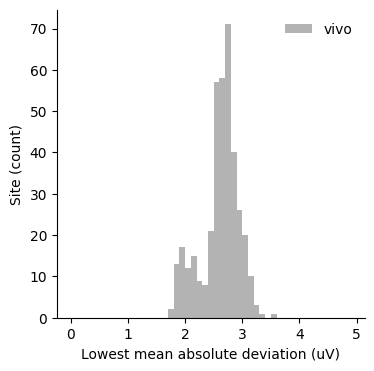

In [16]:
# PLOT

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# hist vivo
ax.hist(
    vivo_noise_by_trace, color=(0.7, 0.7, 0.7), label="vivo", bins=np.arange(0, 5, 0.1)
)

# legend
ax.set_ylabel("Site (count)")
ax.set_xlabel("Lowest mean absolute deviation (uV)")
ax.spines[["right", "top"]].set_visible(False)
ax.legend(frameon=False)
ax.set_box_aspect(1)  # square axis

In [17]:
# sanity check that our sites are in layer 1 of the cortex
# - get layers
silico_layers = PreRecording_h_silico.get_property("layers")
vivo_layers = PreRecording_h_vivo.get_property("layers")

assert vivo_layers[SITE_VIVO] == "L1", "the chosen in vivo site is not in L1"
assert silico_layers[SITE_SILICO] == "L1", "the chosen in silico site is not in L1"

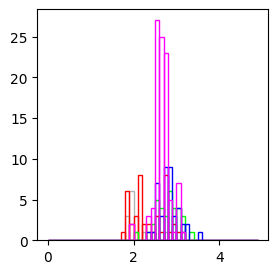

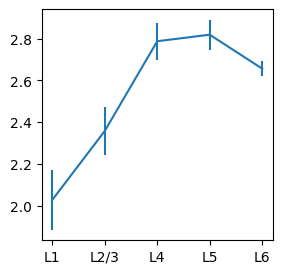

In [15]:
# plot noise distibution by layer

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# hist vivo
ax.hist(
    np.array(vivo_noise_by_trace)[vivo_layers == "L1"],
    edgecolor=(0.7, 0.7, 0.7),
    facecolor="None",
    label="vivo",
    bins=np.arange(0, 5, 0.1),
)


# hist vivo
ax.hist(
    np.array(vivo_noise_by_trace)[vivo_layers == "L2_3"],
    edgecolor=(1, 0, 0),
    facecolor="None",
    label="vivo",
    bins=np.arange(0, 5, 0.1),
)


# hist vivo
ax.hist(
    np.array(vivo_noise_by_trace)[vivo_layers == "L4"],
    edgecolor=(0, 1, 0),
    facecolor="None",
    label="vivo",
    bins=np.arange(0, 5, 0.1),
)

# hist vivo
ax.hist(
    np.array(vivo_noise_by_trace)[vivo_layers == "L5"],
    edgecolor=(0, 0, 1),
    facecolor="None",
    label="vivo",
    bins=np.arange(0, 5, 0.1),
)


# hist vivo
ax.hist(
    np.array(vivo_noise_by_trace)[vivo_layers == "L6"],
    edgecolor=(1, 0, 1),
    facecolor="None",
    label="vivo",
    bins=np.arange(0, 5, 0.1),
)
ax.set_box_aspect(1)  # square axis

# plot noise stats by layer

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

layers = ["L1", "L2_3", "L4", "L5", "L6"]
mean_noise_by_layer_vivo = []
ci95_noise_by_layer_vivo = []

for l_i in range(len(layers)):
    # mean noise by layer
    mean_noise_by_layer_vivo.append(
        np.mean(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])
    )
    # confidence interval 95 of noise by layer
    ci95_noise_by_layer_vivo.append(
        conf_interv95(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])
    )

ax.errorbar(
    x=[1, 2, 3, 4, 5], y=mean_noise_by_layer_vivo, yerr=ci95_noise_by_layer_vivo
)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(["L1", "L2/3", "L4", "L5", "L6"])
ax.set_box_aspect(1)  # square axis

### 3. Fit silico's max amplitude over traces to in vivo's (find gain)

In [18]:
# takes 1 min

# get max amplitudes
max_traces_vivo = traces_vivo.max()
max_traces_silico = traces_silico.max()

# fit in silico's max amplitude to in vivo's (calculate gain ratio)
scale = max_traces_vivo / max_traces_silico
fitted_traces_silico = traces_silico * scale

print("max amplitude (vivo, uV):", max_traces_vivo)
print("max amplitude (silico, uV):", max_traces_silico)
print("vivo/silico gain ratio:", scale)

max amplitude (vivo, uV): 175
max amplitude (silico, uV): 0.3905522837463495
vivo/silico gain ratio: 448.0834123444957


### 3. Fit layer noises

In [19]:
def fit_noise_by_layer(
    traces_vivo, fitted_traces_silico, vivo_layers, silico_layers, layer: str = "L1"
):
    # set seed for reproducibility
    np.random.seed(RND_SEED)

    ## VIVO NOISE -------------

    # measure the average layer sites noise
    vivo_traces = traces_vivo[:, np.where(vivo_layers == layer)[0]].T
    nsites = vivo_traces.shape[0]
    with ProcessPoolExecutor() as executor:
        traces_noise = executor.map(
            measure_vivo_trace_noise_parallel,
            vivo_traces,
            np.arange(0, nsites, 1),
        )
    vivo_traces_noise = list(traces_noise)
    vivo_layer_noise = np.mean(np.array(vivo_traces_noise))
    print("measured noise (in vivo):", vivo_layer_noise)

    ## RAW SILICO NOISE -------------

    # measure the average layer sites noise
    loc_L2_3 = np.hstack(
        [np.where(silico_layers == "L2")[0], np.where(silico_layers == "L3")[0]]
    )
    silico_traces = fitted_traces_silico[:, loc_L2_3].T
    nsites = silico_traces.shape[0]
    with ProcessPoolExecutor() as executor:
        traces_noise = executor.map(
            measure_silico_trace_noise_parallel,
            silico_traces,
            np.arange(0, nsites, 1),
        )
    silico_traces_noise = list(traces_noise)
    silico_layer_noise = np.mean(np.array(silico_traces_noise))
    print("measured noise (in silico):", silico_layer_noise)

    ## FIT --------

    x0 = 5
    MAX_ITER = 15
    TOL = 0.01

    print(" iter     x ")
    results = minimize(
        myfun_layer,
        x0,
        args=(silico_traces, vivo_layer_noise),
        method="Nelder-Mead",
        tol=TOL,
        callback=callback,
        options={"maxiter": MAX_ITER, "disp": True},
    )
    print(results)
    missing_noise = results.x[0]
    print(dir(results))
    print("fit done")

    return missing_noise

In [20]:
# takes 1 min

# measure the average layer sites noise
vivo_traces = traces_vivo[:, np.where(vivo_layers == "L2_3")[0]].T
nsites = vivo_traces.shape[0]
with ProcessPoolExecutor() as executor:
    traces_noise = executor.map(
        measure_vivo_trace_noise_parallel,
        vivo_traces,
        np.arange(0, nsites, 1),
    )
vivo_traces_noise = list(traces_noise)
vivo_layer_noise = np.mean(np.array(vivo_traces_noise))
print("measured noise (in vivo):", vivo_layer_noise)

measured noise (in vivo): 2.3578597496480844


In [172]:
# measure the average layer sites noise
loc_L2_3 = np.hstack(
    [np.where(silico_layers == "L2")[0], np.where(silico_layers == "L3")[0]]
)
silico_traces = fitted_traces_silico[:, loc_L2_3].T
nsites = silico_traces.shape[0]
with ProcessPoolExecutor() as executor:
    traces_noise = executor.map(
        measure_silico_trace_noise_parallel,
        silico_traces,
        np.arange(0, nsites, 1),
    )
silico_traces_noise = list(traces_noise)
silico_layer_noise = np.mean(np.array(silico_traces_noise))
print("measured noise (in silico):", silico_layer_noise)

measured noise (in silico): 0.8449964083720719


In [21]:
# takes 15 min per layer
missing_noise_L1 = fit_noise_by_layer(
    traces_vivo, fitted_traces_silico, vivo_layers, silico_layers, layer="L1"
)

measured noise (in vivo): 2.027459498703704
measured noise (in silico): 0.8449964083720719
 iter     x 
silico noise: 4.0342991006186315
objfun: 2.0068396019149275
silico noise: 4.2262828371278784
objfun: 2.1988233384241744
silico noise: 3.8399086875102024
objfun: 1.8124491888064984
silico noise: 3.649246813175888
objfun: 1.6217873144721842
[4.5]
   1    4.500000
silico noise: 3.265778423809787
objfun: 1.2383189251060829
silico noise: 2.8854022681858584
objfun: 0.8579427694821544
[3.5]
   2    3.500000
silico noise: 2.141873057252043
objfun: 0.11441355854833901
silico noise: 1.4468846338267585
objfun: 0.5805748648769455
[2.5]
   3    2.500000
silico noise: 1.446798673829814
objfun: 0.58066082487389
silico noise: 1.7850845618730713
objfun: 0.24237493683063271
[2.5]
   4    2.500000
silico noise: 2.511065059846654
objfun: 0.48360556114295017
silico noise: 1.961634325888429
objfun: 0.065825172815275
[2.25]
   5    2.250000
silico noise: 1.7853159473378983
objfun: 0.24214355136580568
silic

In [22]:
missing_noise_L1

2.34375

In [135]:
# # takes 30 secs

# # check fit result
# nsites = scaled_traces_silico_target_this_layer.shape[0]
# ntimepoints = scaled_traces_silico_target_this_layer.shape[1]

# # - adjust silico traces with missing noise
# missing_noise_traces = np.random.normal(0, missing_noise, [nsites, ntimepoints])
# with_noise = scaled_traces_silico_target_this_layer + missing_noise_traces

# # measure the each site's noise in that vivo layer
# with ProcessPoolExecutor() as executor:
#     traces_noise = executor.map(
#         measure_silico_trace_noise_parallel,
#         with_noise,
#         np.arange(0, nsites, 1),
#     )

# # measure the noise from this vivo layer
# silico_traces_noise = list(traces_noise)
# silico_layer_noise = np.mean(np.array(silico_traces_noise))

# # check that noises are close
# print("noise (vivo):", vivo_layer_noise)
# print("fitted noise (silico):", silico_layer_noise)

noise (vivo): 2.027459498703704
fitted noise (silico): 2.0314823764117804


In [23]:
# report 1) scaling factor and 2) missing additive noise (RMS or STD)
print("scaling factor:", scale)
print("vivo noise (mad in uV):", vivo_layer_noise)
print("silico noise after scaling (mad in uV):", silico_layer_noise)
print("missing additive noise (RMS in uV):", missing_noise)

scaling factor: 448.0834123444957
vivo noise (mad in uV): 2.3578597496480844


NameError: name 'silico_layer_noise' is not defined

#### plot vivo vs. fitted silico noise by layer

In [28]:
# takes 6 min

# scale and adjust background noise to match in vivo
ntimepoints = traces_silico.shape[0]

# scale traces
scaled_traces_silico = traces_silico * scale
scaled_with_noise = copy.copy(scaled_traces_silico)

for ix in range(len(layers_missing_noise)):
    # add missing noise
    sites = layers_missing_noise[ix]["layer_sites_ix"]
    nsites = len(sites)
    missing_noise_traces = np.random.normal(
        0, layers_missing_noise[ix]["missing_noise_rms"], [ntimepoints, nsites]
    )
    scaled_with_noise[:, sites] = scaled_traces_silico[:, sites] + missing_noise_traces

In [29]:
# takes 5 min

# measure sites' adjusted noise in silico (parallelized, )
with ProcessPoolExecutor() as executor:
    silico_noise_by_trace = executor.map(
        measure_silico_trace_noise_parallel,
        scaled_with_noise.T,
        np.arange(0, scaled_with_noise.shape[1], 1),
    )
silico_noise_by_trace = list(silico_noise_by_trace)

In [44]:
np.array(silico_noise_by_trace)[sites]

array([2.32737882, 2.32206373, 2.32976684, 2.32042769, 2.3110215 ,
       2.33053908, 2.32237684, 2.33813595, 2.3372565 , 2.30771732,
       2.45172737, 2.4066951 , 2.38005772, 2.36401748, 2.34988777,
       2.33562573, 2.32883504, 2.32754117, 2.33528073, 2.4714012 ,
       2.41828214, 2.38777008, 2.36420843, 2.3584971 , 2.34262189,
       2.33527981, 2.32489438, 2.32886024, 2.50335433, 2.44085254,
       2.40216657, 2.38108112, 2.36047043, 2.3516371 , 2.33754501,
       2.33161958, 2.32320988, 2.32487371, 2.46234164, 2.41239789,
       2.3859032 , 2.36848133, 2.36220165, 2.34697989, 2.33323597,
       2.3331593 , 2.33407023])

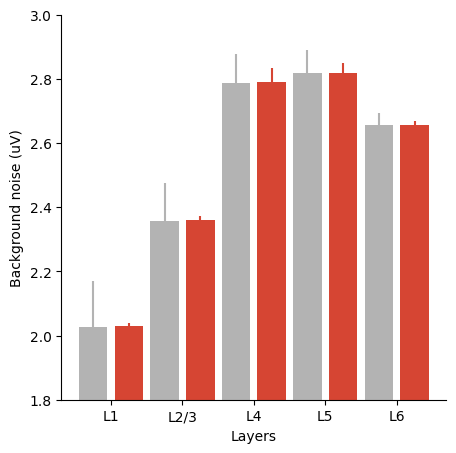

In [82]:
# plot in vivo vs. in silico noise statistics by layer

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

layers = ["L1", "L2_3", "L4", "L5", "L6"]
mean_noise_by_layer_vivo = []
ci95_noise_by_layer_vivo = []
mean_noise_by_layer_silico = []
ci95_noise_by_layer_silico = []

for l_i in range(len(layers)):
    # VIVO

    # mean noise by layer
    mean_noise_by_layer_vivo.append(
        np.mean(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])
    )
    # confidence interval 95 of noise by layer
    ci95_noise_by_layer_vivo.append(
        conf_interv95(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])
    )

    # SILICO

    sites = get_layer_sites(silico_layers, layer=layers[l_i])

    # mean noise by layer
    mean_noise_by_layer_silico.append(np.mean(np.array(silico_noise_by_trace)[sites]))
    # confidence interval 95 of noise by layer
    ci95_noise_by_layer_silico.append(
        conf_interv95(np.array(silico_noise_by_trace)[sites])
    )


# vivo
ax.errorbar(
    x=[1, 2, 3, 4, 5],
    y=mean_noise_by_layer_vivo,
    yerr=ci95_noise_by_layer_vivo,
    linestyle="None",
    color=[0.7, 0.7, 0.7],
)
ax.bar(
    x=[1, 2, 3, 4, 5],
    height=mean_noise_by_layer_vivo,
    width=0.4,
    facecolor=[0.7, 0.7, 0.7],
)
ax.set_xticks([1, 2, 3, 4, 5])

# silico
ax.errorbar(
    x=[1.5, 2.5, 3.5, 4.5, 5.5],
    y=mean_noise_by_layer_silico,
    yerr=ci95_noise_by_layer_silico,
    linestyle="None",
    color=(0.84, 0.27, 0.2),
)
ax.bar(
    x=[1.5, 2.5, 3.5, 4.5, 5.5],
    height=mean_noise_by_layer_silico,
    width=0.4,
    facecolor=(0.84, 0.27, 0.2),
)

ax.set_xticks([1.25, 2.25, 3.25, 4.25, 5.25])
ax.set_xticklabels(["L1", "L2/3", "L4", "L5", "L6"])
ax.set_ylim([1.8, 3])
ax.set_box_aspect(1)  # square axis
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlabel("Layers")
ax.set_ylabel("Background noise (uV)")

# save figures
plt.savefig("figures/2_realism/2_noise/pdf/layerwise_noise_stats_marques.pdf")
plt.savefig("figures/2_realism/2_noise/svg/layerwise_noise_stats_marques.svg")